# Introduction to numerics in Python

This notebook is intended to introduce you to scientific computing in Python. See the notebook `Intro to Python.ipynb` for an introduction to Python.

As you read through this notebook you will see __a lot of functions and classes that you may not have seen before__. While the notebook tries to show you how they are used, you are encouraged to __read relevant documentation__ to understand what they do, and/or play around with them by __creating new cells__ (or a new notebook if you don't want to careful about overwriting variables). Here are links to documentation for [numpy and scipy](https://docs.scipy.org/doc/numpy/reference/), and [matplotlib](https://matplotlib.org/contents.html).

The basic idea of numerical computing is this: instead of describing $f(x)$ as an abstract mathematical function, I may describe it by sampling it at enough values of $x$ such that I get a reasonable idea of what it looks like. As long as I can calculate enough function values, I can plot the function and describe it simply, no matter how long and ugly its mathematical closed form is, or even if it doesn't exist. Several functions have no analytic closed forms in terms of elementary mathematical functions and are only evaluated numerically when required. Since we can't evaluate the function at each of the infinite number of points over which it is defined, we approximate the continuous domain to a discrete set. So, for example, instead of working primarily with the function `f`, I'll define a domain `x` that I am intersted in, say between 0 and 1, and sample inputs from there. Then I'll calculate the function values and do whatever else I want with them.

### Contents
- [Plotting](#plot)
- [Solving equations](#eqn)
- [Taking derivatives](#deriv)
- [Discretising continuous systems](#disc)
- [Solving differential equations](#diffeq)
- [Numerical integration](#int)
- [Reading and writing data](#data)
- [Fourier transforms](#fourier)
- [Fitting](#fit)
- [Random numbers](#stats)

<a name="plot"></a>
### Plotting

The most common plotting package for Python is `matplotlib`.

In [1]:
import numpy as np #see the notebook "Intro to Python.ipynb" if you don't know what NumPy is.
from matplotlib import pyplot as plt

%matplotlib inline
#magic function that sets the plots to display inline

The magic `%pylab inline` is a convenient way to do the same things above, but it wildcard imports both NumPy and pyplot (which saves typing `np` and `plt` all the time but overwrites a lot of native Python functions). We do not do it here for pedagogical purposes.

Plotting is easy:

Text(0.5,1,'Example plot: $f(x)=\\frac{x^2}{2}$')

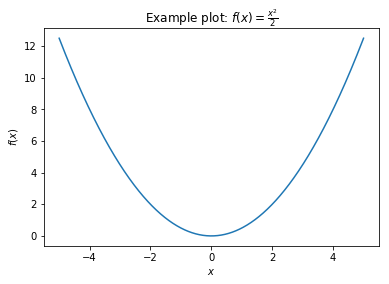

In [2]:
x = np.linspace(-5,5,1000) #takes 1000 values equally spaced between -5 and 5
f = x**2/2

plt.plot(x, f)
plt.xlabel("$x$") #Using LaTeX
plt.ylabel("$f(x)$")
plt.title(r"Example plot: $f(x)=\frac{x^2}{2}$")

#the r escapes the backslash in the string, which would otherwise be 
#interpreted as a special character "\f" (try removing it)

Text(0.5,1,'$\\sin((2\\pi)^r)$')

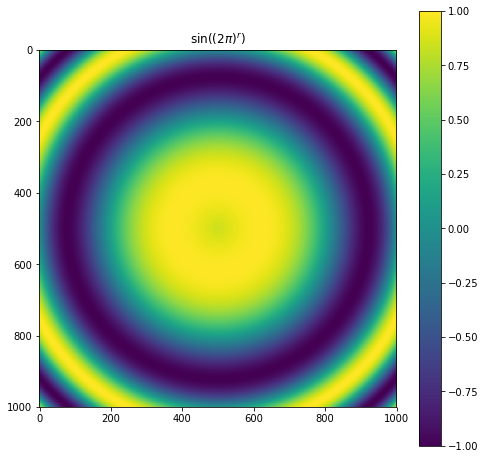

In [3]:
x = np.linspace(-1,1,1000)
y = np.linspace(-1,1,1000)
x,y = np.meshgrid(x,y) #creates 2d array with corresponding values of x,y
#to understand what meshgrid() does, try plotting x or y ("plt.imshow(x)")
r = np.sqrt(x**2+y**2) #radius
g = np.sin((2*np.pi)**r) #some function of r

plt.figure(figsize=(8,8)) #create figure object on which the plot will be renderred
plt.imshow(g) #plots 2d array
plt.colorbar()
plt.title(r"$\sin((2\pi)^r)$")

(-4.5, 4.5)

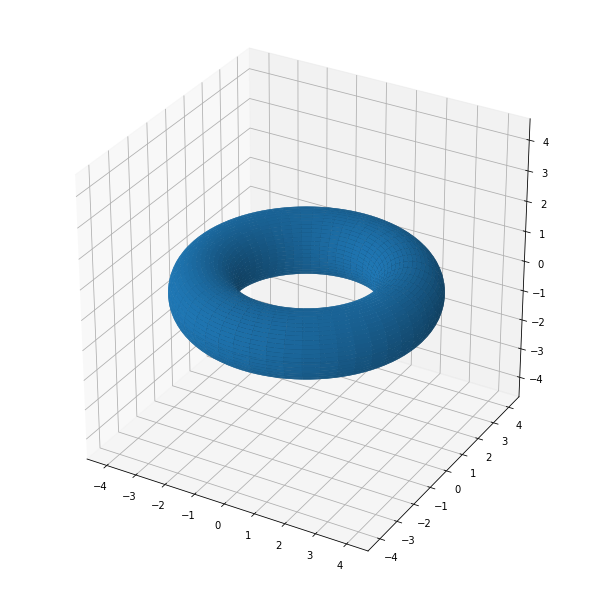

In [4]:
#%matplotlib notebook
#uncomment to set the plots to display interactively (useful for 3d plotting, you can rotate the view by dragging)
#might not work in all environments (works on datahub), and might mess with the animation later on

from mpl_toolkits.mplot3d import Axes3D #import the class for 3d plotting 

r, R = 1, 3 #radii of torus
theta, phi = np.linspace(0,2*np.pi,100), np.linspace(0,2*np.pi,100) #parametrise torus
theta, phi = np.meshgrid(theta, phi) #surface is 2d, need 2d array of points
x = (R + r*np.cos(phi)) * np.cos(theta) #x,y,z coordinates of points parametrised by theta,phi
y = (R + r*np.cos(phi)) * np.sin(theta)
z = r * np.sin(phi)

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig) #create Axes3D object to display the plot
ax.plot_surface(x,y,z)

#explicitly set range of axes (just to keep the aspect ratios equal)
bound = R + r + 0.5
bounds = (-bound, bound)
ax.set_xlim(*bounds)
ax.set_ylim(*bounds)
ax.set_zlim(*bounds)

Since plotting is an essential part of numerical computing, you will learn how to plot as you work through the rest of the examples in the notebook. We'd recommend [this notebook](https://github.com/data-8/physics-connector/blob/master/fa18/Week5/Lecture03.ipynb) from Prof. Yury Kolomensky's Fall 2018 Physics 77 class, in addition to the extensive matplotlib documentation for more examples and information about plotting.

<a name="eqn"></a>
### Solving equations

Sometimes equations are very difficult to solve analytically. Sometime they don't have closed form expressions, and sometimes their closed forms are too cumbersome. For example, try solving the transcendental equation $$e^{-x}=x.$$ However on a computer, this is easy. We can evaluate $e^x$ for a large number of different $x$ and check where they're approximately equal by plotting them and looking for the point of the intersection. Since the answer is obviously positive and less than 1, let's plot the interval $[0,1]$.

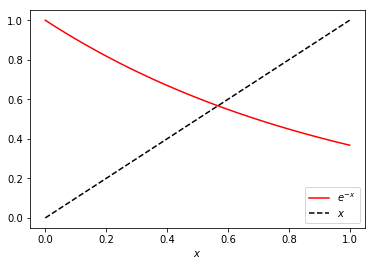

In [5]:
#%matplotlib notebook
npoints = 100 #try changing this to see how many points you need for a good-looking plot
x = np.linspace(0,1,npoints)
f = np.exp(-x)
plt.plot(x, f, color="red", linestyle="-", label="$e^{-x}$") #setting colour and linestyle properties and adding label
plt.plot(x, x, c="k", ls="--", label="$x$") #short form for colour and linestyle
plt.xlabel("$x$")
plt.legend() #display labels in a legend

In [6]:
%matplotlib inline
#interactivity won't be useful from here on out, so let's turn it off...
#unless you don't want to - feel free not to run this cell

We can see from the above plot (if you've enabled interactivity, try hovering your mouse over the intersection point to estimate $x$) that $x\approx0.55$. We can solve the equation using a root-finding algorithm. The simplest and most intuitive one is Newton's method, discussed in the previous notebook. It updates the next guess for the root based on linearly extrapolating from the values of the function and its derivative at the current guess. 

In [7]:
def newton_method(fn, first_guess, epsilon=1e-5, tolerance=1e-10):
    x = first_guess
    while abs(fn(x)) >= tolerance: #while we are not at zero
        df = (fn(x+epsilon/2) - fn(x-epsilon/2))/epsilon #numerical estimate of derivative at x by finite differencing
        x -= fn(x)/df #change x
    #while loop ended, this means we are at zero
    return x

solution = newton_method(lambda x: np.e**-x-x,1)
solution, np.e**-solution

(0.5671432904097838, 0.567143290409784)

So we found a very precise estimate for the solution! There are several other root finding algorithms in the [`scipy.optimize` module](https://docs.scipy.org/doc/scipy-0.19.0/reference/optimize.html).

Newton's method needs the derivative of a function, and we estimated it by _finite differencing_. While this is fairly intuitive, let's study it a little further to understand the limitations of computer arithmetic.

<a name="deriv"></a>
### Taking derivatives

The derivative is defined as$$\frac{df}{dx}=\lim_{\epsilon\rightarrow0}\frac{f(x+\epsilon)-f(x)}{\epsilon}.$$ While the computer can numerically evaluate this for small, finite values of $\epsilon$, it cannot go to the analytic limit. However, we can get good estimates without going to the limit. There are several ways to define the derivative that are equivalent inside the limit. Let's keep track of the centred derivative, where we compare two points equally spaced from $x$, and the derivatives where we compare $x$ with the points $\epsilon$ away to the left and right, which we'll call the _forward_ and _backward_ derivatives. Specifically, \begin{align}D_{\rm centred}[f,\epsilon](x)&=\frac{f(x+\tfrac{1}{2}\epsilon)-f(x-\tfrac{1}{2}\epsilon)}{\epsilon},\\D_{\rm forward}[f,\epsilon](x)&=\frac{f(x+\epsilon)-f(x)}{\epsilon},\\D_{\rm backward}[f,\epsilon](x)&=\frac{f(x)-f(x-\epsilon)}{\epsilon}.\end{align}

In [8]:
def derivative(fn, epsilon=1e-5, mode="centred"):
    if mode=="centred":
        return lambda x: (fn(x+epsilon/2)-fn(x-epsilon/2))/epsilon
    if mode=="forward":
        return lambda x: (fn(x+epsilon)-fn(x))/epsilon
    if mode=="backward":
        return lambda x: (fn(x)-fn(x-epsilon))/epsilon

Let's use some arbitrary polynomial to compare derivatives.

Text(0,0.5,'$f(x)$')

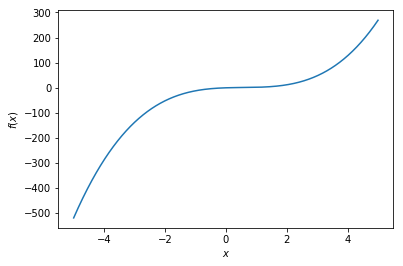

In [9]:
x = np.linspace(-5,5,1000)
f = lambda x: 3*x**3-5*x**2+4*x-1 #some polynomial function
plt.plot(x, f(x))
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

First let's try to use a largish $\epsilon$. We shouldn't expect very accurate results. (Even more so for rapidly-changing functions.) We'll compare the numerical derivatives to the exact, analytic derivative.

Text(0.5,1,'$\\epsilon=0.1$')

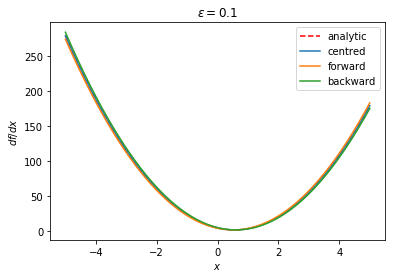

In [10]:
analytic_df = lambda x: 9*x**2-10*x+4

modes = ["centred", "forward", "backward"] #list of mode labels
derivatives = [derivative(f, mode=m, epsilon=0.1) for m in modes] #corresponding list of derivative functions

plt.plot(x, analytic_df(x), "r--", label="analytic") #"r--" is a short way to set color="r", linestyle="--"
for m,d in zip(modes,derivatives): #iterate through mode labels and derivative functions simultaneously
    plt.plot(x, d(x), label=m) #plot each derivative with corresponding label
plt.legend()
plt.xlabel("$x$")
plt.ylabel(r"$df/dx$")
plt.title(r"$\epsilon=0.1$")

We seem to have got a pretty good estimate even for such a large value of $\epsilon$. Let's plot the fractional error in our estimates to get a clearer picture of how well it's doing.

Text(0.5,1,'$\\epsilon=0.1$')

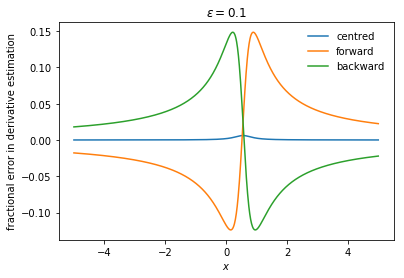

In [11]:
for m,d in zip(modes,derivatives):
    plt.plot(x, d(x)/analytic_df(x)-1, label=m)
plt.legend(frameon=False)
plt.xlabel("$x$")
plt.ylabel("fractional error in derivative estimation")
plt.title(r"$\epsilon=0.1$")

So it turns out we're actually off by upto 15%, which is closer to what we were expecting. As we saw here, choosing what to plot and how to plot it is very important. Now let's try fixing $x$ and varying $\epsilon$. We'd expect to get good estimates for smaller values of $\epsilon$.

(1.0, 1e-16)

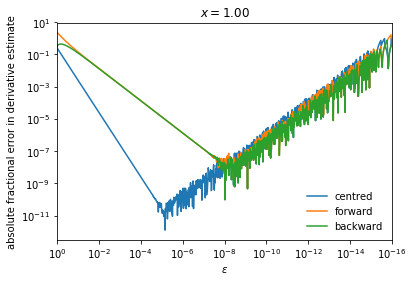

In [12]:
x0 = 1.
epsilons = np.logspace(-16,0,1000) #like linspace, except samples equally in log-space. equivalent to 10**linspace(...)
errors = np.array([[derivative(f, epsilon=eps, mode=m)(x0) for eps in epsilons] for m in modes])
#estimate derivates and store them in the ndarray named errors
errors = np.abs(errors/analytic_df(x0) - 1) #calculate absolute fractional errors

for m,e in zip(modes,errors):
    plt.plot(epsilons, e, label=m)
plt.legend(loc=4, frameon=False) #locations numbered ccw starting with 1 at top-right
plt.xlabel(r"$\epsilon$")
plt.ylabel("absolute fractional error in derivative estimate")
plt.title(f"$x={x0:.2f}$")
plt.xscale("log")
plt.yscale("log")
plt.xlim(np.amax(epsilons),np.amin(epsilons)) #set the limits of the x-axis so that epsilon 
                                              #is decreasing (and there's no whitespace on the right/left)

One might expect the error to keep getting smaller as we decrease $\epsilon$, since the derivative is defined in the limit $\epsilon\rightarrow0$. If we were doing the calculation on paper, it would keep decreasing. However, since we are using a digital computer, the representation of numbers only have a finite level of precision, and as we compare numbers that are closer together, the fractional error due to this misrepresentation becomes larger (for more information see the previous notebook). The smallest value of $\epsilon$ that we can trust depends on $f$ and $x$.

In practice we can try a few different $\epsilon$ and extrapolate if we really want to minimise error, but in such situations it is better to fit or interpolate a function (more on this [later](#fit)) and use analytic gradients, which are always preferred.

<a name="disc"></a>
### Discretising continuous systems

As we saw above, computers are discrete systems. Floating-point numbers might seem continuous, but they are implicitly discrete. When we plot things, we used discrete values that represet the continuum. Since we are implicitly discretising anyway, why not discretise explicitly? After all, since quantum effects dominate at small scales, spacetime itself must be fundamentally discrete. However, as we shall see here, we don't need to quantise gravity to discretise systems. In fact this approximation is often made to link field theories with lattice theories and to think concretely about continuous things.

Essentially we replace continuous intervals of space and/or time by a discrete set of values, which are essentially indices $i$ representing points $\mathbf x_i$. Any function on this space is then a set of values corresponding to these points $f(\mathbf x) \rightarrow f_i$, which we can think of as an $N$-dimensional vector when we have $N$ spacetime points. Explicitly, $$f\rightarrow\begin{pmatrix}f(x_1)\\f(x_2)\\\vdots\\f(x_N)\end{pmatrix}.$$ Integrals correspond to sums over the function values, with the appropriates volume/area/length elements e.g. $\int f(x)\:d x\rightarrow \sum_i f_i \Delta x_i$, where $\Delta x_i = x_{i+1}-x_i$. It is simpler to use regular grids where $\Delta x$ is constant. We recover the continuum limit when $N\rightarrow\infty$, i.e. $\Delta x\rightarrow 0$. even in the continuum limit, we can think of functions as vectors in an infinite-dimensional space.

The derivative is a linear operator mapping functions (vectors) to functions (vectors). Hence, in the discretised system it can be represented by a matrix. For example, using the centred derivative on a regular 1-d grid, we'd have$$\frac{d}{dx}\rightarrow\frac{1}{2\Delta x}\begin{pmatrix}-2&2&0&\cdots\\-1&0&1&0&\cdots\\0&-1&0&1&0&\cdots\\\vdots&0&-1&0&1&0&\cdots\\&\vdots&0&-1&0&1&\ddots\\&&\vdots&0&-1&0&\ddots\\&&&\vdots&\ddots&\ddots&\ddots\end{pmatrix}.$$ Keep in mind that a derivative gets rid of a degree of freedom (think of polynomials), and that in discretised space we only have $N$ dofs. With this representation, differential equations become matrix equations!

For example, let's try to solve Schr&ouml;dinger's equation for the quantum harmonic oscillator$$H\psi=\left(-\frac{\hbar^2}{2m}\frac{d^2}{dx^2}+\frac{1}{2}m\omega^2x^2\right)\psi = E\psi.$$ As usual, the stationary states are the eigenstates of the Hamiltonian, except now we start with a finite-dimensional position space. If we sample $x$ only upto some maximum value $x_0$, we would expect to describe only those energy levels satisying $E_n\ll V(x_0)$, i.e. $n\ll \frac{m\omega x_0^2}{2\hbar}$.

[[-10.  10.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ -5.   0.   5.   0.   0.   0.   0.   0.   0.   0.]
 [  0.  -5.   0.   5.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  -5.   0.   5.   0.   0.   0.   0.   0.]
 [  0.   0.   0.  -5.   0.   5.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  -5.   0.   5.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  -5.   0.   5.   0.   0.]
 [  0.   0.   0.   0.   0.   0.  -5.   0.   5.   0.]
 [  0.   0.   0.   0.   0.   0.   0.  -5.   0.   5.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -10.  10.]]


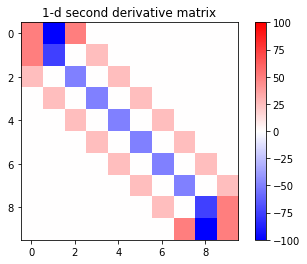

In [13]:
def deriv(dx,N):
    der = np.zeros((N,N))
    for i in range(N-1):
        der[i+1,i]=-1 #set -1s above diagonal
        der[i,i+1]=1 #set 1s below diagonal
    der[0,0]=-2 #handle corners
    der[0,1]=2
    der[-1,-1]=2
    der[-1,-2]=-2
    return der/2/dx

firstd = deriv(0.1,10)
secondd = np.dot(firstd,firstd) #dot is for matrix multiplication, * is element-wise multiplication
bound = np.amax(np.abs(secondd)) #find maximum absolute value for normalisation of colour plot
plt.imshow(secondd, cmap="bwr", vmin=-bound, vmax=bound) 
#using one of matplotlib's predefined colourmaps, and setting the maximum and minimum values so that white=0
plt.colorbar() #add a colourbar for reference
plt.title("1-d second derivative matrix")

print(firstd) #we can also just print this since it's really small

Since we used a centred first derivative, our second derivative operator got more spread out than it needs to be. We can construct a centred second derivative operator directly, though the two should give similar results.

[[ 100. -200.  100.    0.    0.    0.    0.    0.    0.    0.]
 [ 100. -200.  100.    0.    0.    0.    0.    0.    0.    0.]
 [   0.  100. -200.  100.    0.    0.    0.    0.    0.    0.]
 [   0.    0.  100. -200.  100.    0.    0.    0.    0.    0.]
 [   0.    0.    0.  100. -200.  100.    0.    0.    0.    0.]
 [   0.    0.    0.    0.  100. -200.  100.    0.    0.    0.]
 [   0.    0.    0.    0.    0.  100. -200.  100.    0.    0.]
 [   0.    0.    0.    0.    0.    0.  100. -200.  100.    0.]
 [   0.    0.    0.    0.    0.    0.    0.  100. -200.  100.]
 [   0.    0.    0.    0.    0.    0.    0.  100. -200.  100.]]


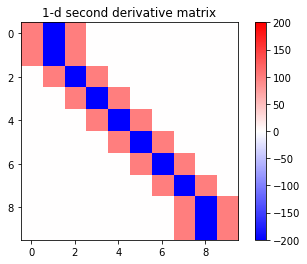

In [14]:
def second_deriv(dx,N):
    der = np.zeros((N,N))
    for i in range(1,N-1):
        der[i,i+1]=1 #set 1s above diagonal
        der[i,i]=-2 #set -2s on diagonal
        der[i,i-1]=1 #set 1s below diagonal
    der[0]=der[1] #corners: copy neighbour
    der[-1]=der[-2]
    return der/dx**2

secondd = second_deriv(0.1,10)
bound = np.amax(np.abs(secondd))
plt.imshow(secondd, cmap="bwr", vmin=-bound, vmax=bound)
plt.colorbar()
plt.title("1-d second derivative matrix")

print(secondd)

Note that since we lose 2 degrees of freedom, we might as well describe the matrix as an $(N-2)\times N$, rather than square, matrix.

Let's rescale variables, so that, by redefining $x\rightarrow C x$ we can get rid of as many variables as possible. Then $$H=-\frac{\hbar^2C^2}{2m}\frac{d^2}{dx^2}+\frac{m\omega^2}{2C^2}x^2.$$ If we define $C^2=\frac{m\omega}{\hbar}$ then $$H=\frac{\hbar\omega}{2}\left(-\frac{d^2}{dx^2}+x^2\right).$$ We have non-dimensionalised the problem, and found the natural units to measure the distance, $\sqrt{\hbar/m\omega}$, and energy, $\hbar\omega$. This means we don't have to worry about units (which are often the most annoying part of computational physics), and can implicitly measure everything in these natural units.

To find the spectrum, we need to diagonalise the Hamiltonian. There are several algorithms for efficient matrix manipulation, inversion, and decomposition, which are worthy of a course on their own, but we shall not discuss here. <font color="red">add some sentences/links?</font> We shall use tools from NumPy's [`linalg` module](https://docs.scipy.org/doc/numpy/reference/routines.linalg.html).

In [15]:
x0 = 5
N = 500
x_grid = np.linspace(-x0,x0,N)
dx = x_grid[1]-x_grid[0] #also see np.d() for non-regular grids

H = (-second_deriv(dx,N) + np.diag(x_grid**2))/2 #diag sets elements on diagonal
eigvals, eigvecs = np.linalg.eig(H) #get eigenvalues and eigenvectors of H

#let's only keep low-energy levels since we only expect accuracy upto n << x0**2/2
to_keep = eigvals < x0**2/2
eigvals, eigvecs = eigvals[to_keep], eigvecs[:,to_keep]

#now let's sort them
sorted_indices = np.argsort(eigvals)
eigvals, eigvecs = eigvals[sorted_indices], eigvecs[:, sorted_indices]

eigvals

array([ 0.49998745+0.j,  1.49993724+0.j,  2.49983676+0.j,  3.49968513+0.j,
        4.49947458+0.j,  5.49915481+0.j,  6.49848684+0.j,  7.49667785+0.j,
        8.49228676+0.j,  9.48682376+0.j, 10.50069628+0.j, 11.61221326+0.j])

The energy levels seem to be accurate! Let's look at the computed wavefunctions, making the canonical plot:

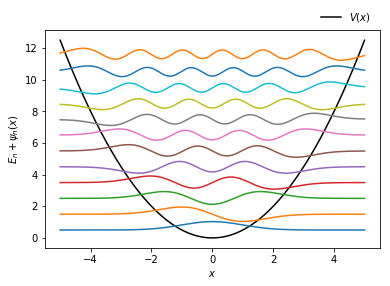

In [16]:
plt.plot(x_grid, x_grid**2/2, c="k", label="$V(x)$") #plot potential

for i in range(len(eigvals)):
    plt.plot(x_grid, np.real(eigvals[i]+5*eigvecs[:,i])) #plot wavefunctions offset by energies
    
plt.xlabel("$x$")
plt.ylabel(r"$E_n+\psi_n(x)$")
plt.legend(frameon=False, loc="upper right", bbox_to_anchor=[1,1.13]) #display legend outside plot

We get accurate wavefunctions where expected!

However, with $N$ points, we'd have to use an $N\times N$ matrix, which is expensive both in storage and computation (at least $N^2$ in each). Besides, this method would only work for linear differential equations and there is no scope for boundary conditions. We clearly need better ways to solve differential equations.

<a name="diffeq"></a>
### Solving differential equations

#### Euler method

We can solve initial value problems by simulating the system using finite differences like we did for differentiation. For example, if we have equations of motion $$\ddot{x}=f(\dot{x},x,t),$$ and initial conditions for $x$ and $\dot x$, then we would discretise time, and update $x$ and $\dot x$ at each step according to $$x_{i+1}=x_i+\dot x_i \Delta t_i,\\\dot x_{i+1} = \dot{x_i}+f(\dot{x}_i,x_i,t_i)\Delta t_i.$$ This is known as [Euler's method](https://en.wikipedia.org/wiki/Euler_method). <font color="red">Better links than wikipedia - suggestions?</font>

Let's apply it to something simple: 1d motion in constant gravity. In this case $f(\dot{x},x,t)=-g$.

In [17]:
def euler_method(t, x0, v0, fn):
    N = len(t)
    x = np.zeros((N,len(x0))) #for n-dimensional positions, velocities
    v = np.zeros((N,len(v0)))
    x[0] = x0
    v[0] = v0
    for i in range(1,N):
        dt = t[i] - t[i-1]
        x[i] = x[i-1] + v[i-1]*dt
        v[i] = v[i-1] + fn(x[i-1],v[i-1],t[i-1])*dt
    return x, v

Text(0,0.5,'$x(t)$ [metres]')

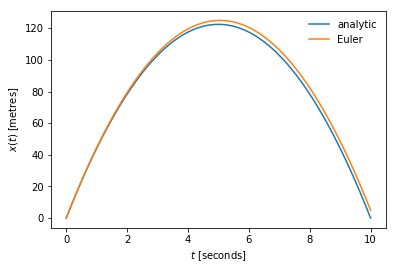

In [18]:
N = 100 #number of time steps; try changing
g = 9.8 #units are m for distance and s for time
t = np.linspace(0,10,N)
x0 = np.array([0])
v0 = np.array([g*t[-1]/2])

analytic_x = x0 + v0*t - g*t**2/2
euler_x, v = euler_method(t, x0, v0, lambda x,v,t: -g)

plt.plot(t, analytic_x, label="analytic")
plt.plot(t, euler_x, label="Euler")
plt.legend(frameon=False)
plt.xlabel("$t$ [seconds]")
plt.ylabel("$x(t)$ [metres]")

It does pretty well even with the coarse timesteps of 0.1 second.

Now let's apply it to planetary orbits, $f(\dot{\mathbf x},\mathbf x,t)=-GM\hat{\mathbf x}/\mathbf x^2$.

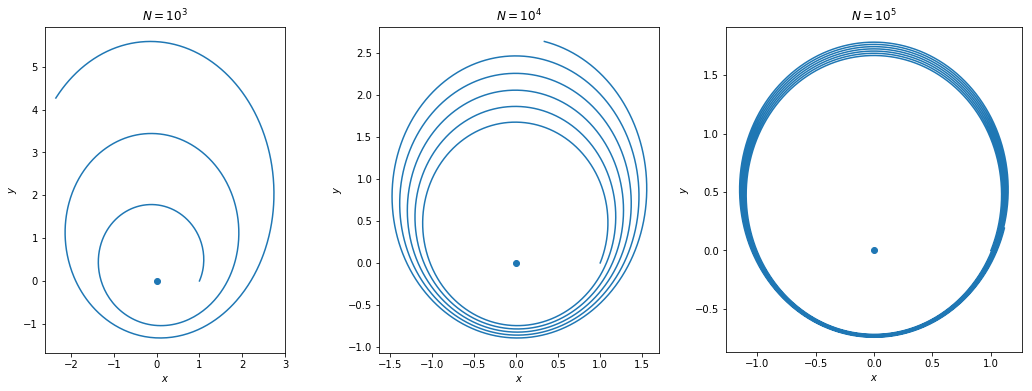

In [19]:
Ns = [3,4,5]
planet_tmax = 60
planet_x0 = np.array([1,0]) #let's not worry about units for now
planet_v0 = np.array([0.4,1])
star_gravity = lambda x,v,t: -x/np.sum(x**2)**1.5

f, axes = plt.subplots(1, len(Ns), figsize=(6*len(Ns),6)) #creates grid of axes for plotting
#f refers to figure, axes is an array of axis objects

for ax,N in zip(axes,Ns): #iterate through axes and Ns simultaneously to create each plot
    times = np.linspace(0, planet_tmax, 10**N)
    position, velocity = euler_method(times, planet_x0, planet_v0, star_gravity)
    
    ax.plot(*position.T) #plot trajectory on specific axis object
    ax.set_title(f"$N=10^{N}$")
    ax.scatter(0,0) #plot star at centre
    ax.set_aspect("equal") #equal aspect ratios
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")

The orbits are supposed to be exactly elliptical, so Euler's method isn't doing too well, though it does seem to get better with $N$. Let's plot energy as a function of time.

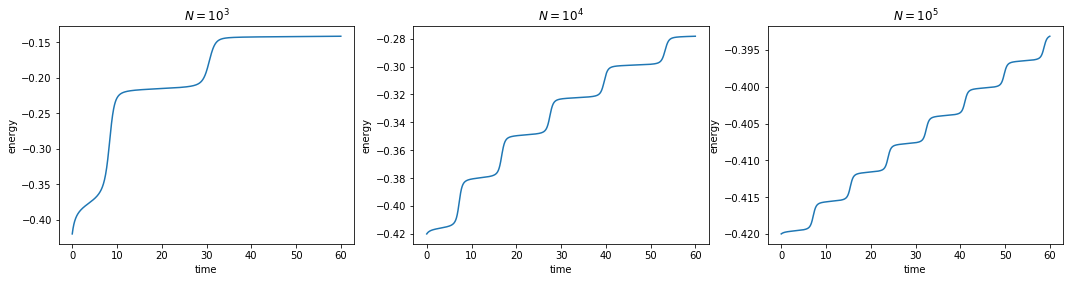

In [20]:
f, axes = plt.subplots(1, len(Ns), figsize=(6*len(Ns),4))
for ax,N in zip(axes,Ns):
    times = np.linspace(0, planet_tmax, 10**N)
    position, velocity = euler_method(times, planet_x0, planet_v0, star_gravity)
    energy = -1/np.sum(position**2, axis=1)**.5 + np.sum(velocity**2, axis=1)/2
    ax.plot(times, energy)
    ax.set_title(f"$N=10^{N}$")
    ax.set_xlabel("time")
    ax.set_ylabel("energy")

Energy is not conserved by the Euler method!

Let's simulate simple harmonic oscillation, $f(\dot x,x,t)=-\omega^2 x$.

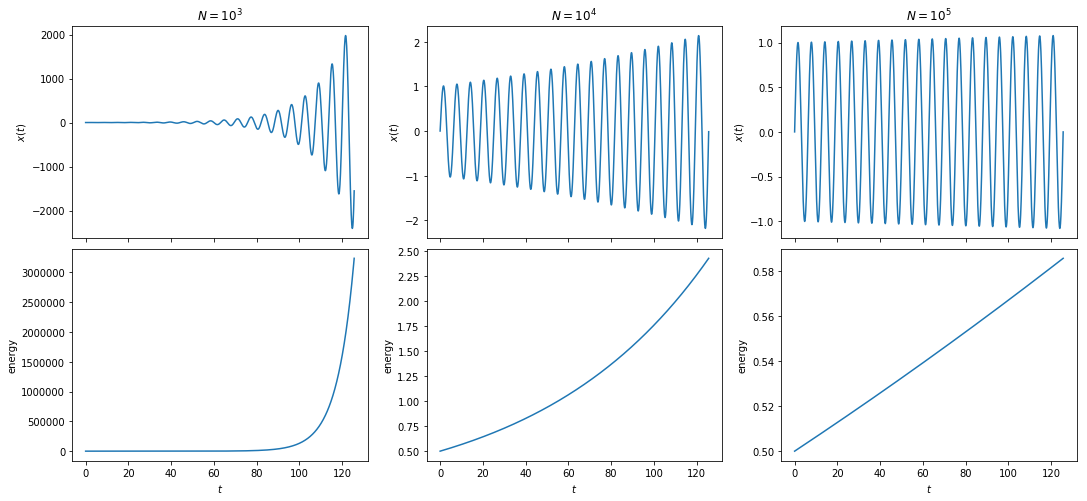

In [21]:
tmax = 40*np.pi
x0 = np.array([0]) #let's not worry about units for now
v0 = np.array([1])
restoring_force = lambda x,v,t: -x

f, ax = plt.subplots(2, len(Ns), sharex=True, figsize=(6*len(Ns),8), gridspec_kw={"hspace": 0.05})
#sharex tells the plots to have the same x axis
#gridspec_kw is used for additional formatting specifications (see docs)

for i in range(len(Ns)):
    times = np.linspace(0, tmax, 10**Ns[i])
    x,v = euler_method(times, x0, v0, restoring_force)
    energy = (np.sum(x**2, axis=1) + np.sum(v**2, axis=1))/2
    ax[0][i].plot(times, x)
    ax[0][i].set_title(f"$N=10^{Ns[i]}$")
    ax[0][i].set_ylabel("$x(t)$")
    ax[1][i].plot(times, energy)
    ax[1][i].set_xlabel("$t$")
    ax[1][i].set_ylabel("energy")

#### Symplectic Euler
One of the reasons that the Euler method fails is that it doesn't preserve volumes in phase space: it is not symplectic. You will learn more about this in your analytical mechanics course. We can fix this simply by updating positions using velocities at the current time step rather than the previous one, i.e. $$x_{i+1}=x_i+\dot x_{i+1} \Delta t_i,\\\dot x_{i+1} = \dot{x_i}+f(\dot{x}_i,x_i,t_i)\Delta t_i.$$ This is known as [symplectic Euler](https://en.wikipedia.org/wiki/Semi-implicit_Euler_method).

In [22]:
def symplectic_euler(t, x0, v0, fn):
    N = len(t)
    x = np.zeros((N,len(x0))) #for n-dimensional positions, velocities
    v = np.zeros((N,len(v0)))
    x[0] = x0
    v[0] = v0
    for i in range(1,N):
        dt = t[i] - t[i-1]
        v[i] = v[i-1] + fn(x[i-1],v[i-1],t[i-1])*dt
        x[i] = x[i-1] + v[i]*dt
    return x, v

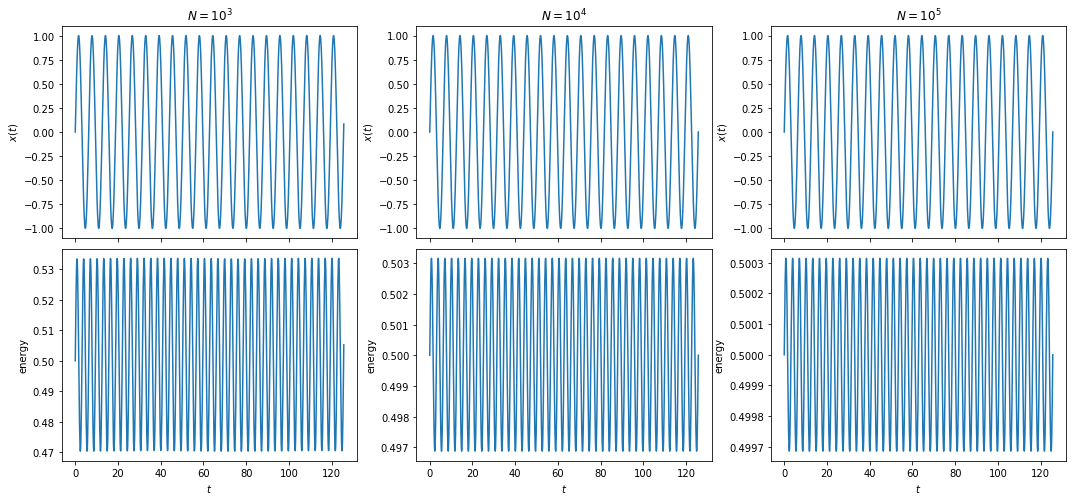

In [23]:
f, ax = plt.subplots(2, len(Ns), sharex=True, figsize=(6*len(Ns),8), gridspec_kw={"hspace": 0.05})
for i in range(len(Ns)):
    times = np.linspace(0, tmax, 10**Ns[i])
    x,v = symplectic_euler(times, x0, v0, restoring_force)
    energy = (np.sum(x**2, axis=1) + np.sum(v**2, axis=1))/2
    ax[0][i].plot(times, x)
    ax[0][i].set_title(f"$N=10^{Ns[i]}$")
    ax[0][i].set_ylabel("$x(t)$")
    ax[1][i].plot(times, energy)
    ax[1][i].set_xlabel("$t$")
    ax[1][i].set_ylabel("energy")

The energy still changes, but only oscillates slightly, and nothing blows up for long times.

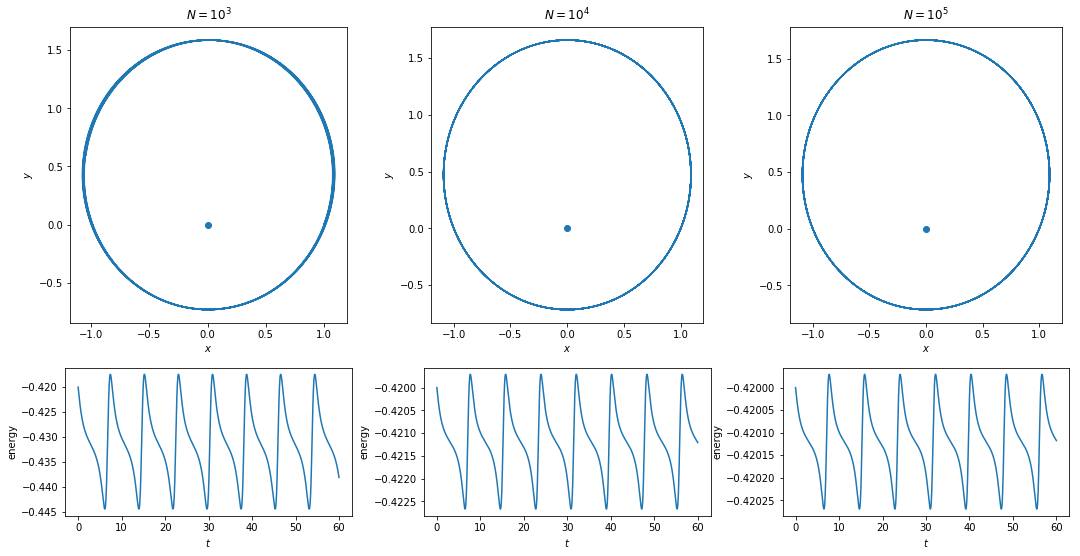

In [24]:
f, ax = plt.subplots(2, len(Ns), gridspec_kw={"height_ratios": (2,1), "wspace":0.25}, figsize=(6*len(Ns),9))
for i in range(len(Ns)):
    times = np.linspace(0, planet_tmax, 10**Ns[i])
    position, velocity = symplectic_euler(times, planet_x0, planet_v0, star_gravity)
    energy = -1/np.sum(position**2, axis=1)**.5 + np.sum(velocity**2, axis=1)/2
    ax[0][i].plot(*position.T)
    ax[0][i].set_title(f"$N=10^{Ns[i]}$")
    ax[0][i].scatter(0,0) #plot centre
    ax[0][i].set_aspect("equal") #equal aspect ratios
    ax[0][i].set_xlabel("$x$")
    ax[0][i].set_ylabel("$y$")
    ax[1][i].plot(times, energy)
    ax[1][i].set_xlabel("$t$")
    ax[1][i].set_ylabel("energy")

We see that the orbits are now closed, and the energy is much more constant than it was before.

#### Packaged solvers

The package `scipy` has more efficient and accurate algorithms to solve initial value problems in the [`integrate` module](https://docs.scipy.org/doc/scipy/reference/integrate.html). Below are solutions to SHO and planetary orbits using a [Runge-Kutta method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods), which updates values at each step according to values in between the current and previous step. This allows us to get more accurate answers even with larger timesteps. (Though it is not symplectic.)

Text(0,0.5,'energy')

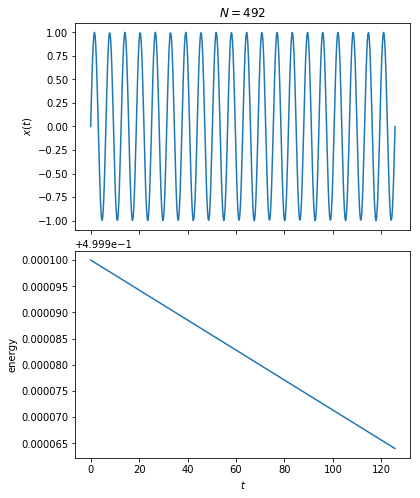

In [25]:
from scipy import integrate

time_range = 0, 40*np.pi
initial_state = [0, 1] #phase-space state is position and velocity (restate as 1st order ODE)
restoring_force = lambda time, state: [state[1], -state[0]]
relative_error_tolerance = 1e-7 #what precision do you want? try changing

soln = integrate.solve_ivp(restoring_force, time_range, initial_state, rtol=relative_error_tolerance)
times = soln.t
states = soln.y
energy = np.sum(states**2, axis=0)/2

f, ax = plt.subplots(2, 1, sharex=True, figsize=(6,8), gridspec_kw={"hspace": 0.1})
ax[0].plot(times,states[0])
ax[0].set_title(f"$N={len(times)}$")
ax[0].set_ylabel("$x(t)$")
ax[1].plot(times, energy)
ax[1].set_xlabel("$t$")
ax[1].set_ylabel("energy")

Text(0,0.5,'energy')

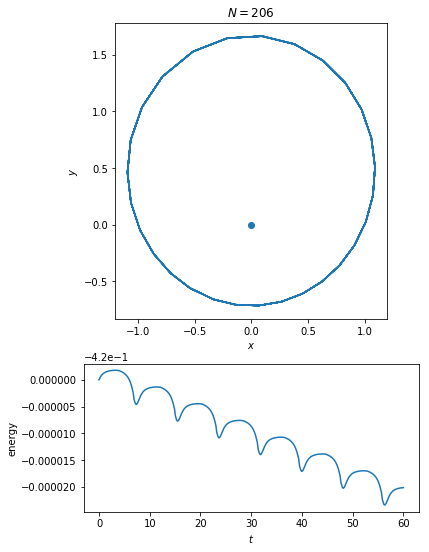

In [26]:
time_range = 0, 60
initial_state = [1, 0, 0.4, 1]
star_gravity = lambda time, state: np.concatenate((state[-2:], -state[:2]/np.sum(state[:2]**2)**1.5))
relative_error_tolerance = 1e-7

soln = integrate.solve_ivp(star_gravity, time_range, initial_state, rtol=relative_error_tolerance)
times = soln.t
states = soln.y
position, velocity = states[:2], states[2:]
energy = -1/np.sum(position**2, axis=0)**.5 + np.sum(velocity**2, axis=0)/2

f, ax = plt.subplots(2, 1, gridspec_kw={"height_ratios": (2,1)}, figsize=(6,9))
ax[0].plot(*position)
ax[0].set_title(f"$N={len(times)}$")
ax[0].scatter(0,0) #plot centre
ax[0].set_aspect("equal") #equal aspect ratios
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$y$")
ax[1].plot(times, energy)
ax[1].set_xlabel("$t$")
ax[1].set_ylabel("energy")

However not all differential equations are initial value problems. For boundary value problems, one technique is _relaxation_, in which we discretise the domain and iteratively set the value at each point to a mean of its neighbours. For example, if we are solving 1-d kinematics in gravity, and we know that the particle starts at $t=0$ at $x=0$, and at $t=10\:\rm s$ is at $x=300\:\rm m$, we cannot use an initial value problem solver. We are solving the equation $$\frac{d^2x}{dt^2}\approx \frac{x_{i+1}-2x_i+x_{i-1}}{(\Delta t)^2}=-g$$ with boundary conditions, so for all the points not on the boundary, we set $$x_i = \frac{1}{2}\left(x_{i+1}+x_{i-1}+(\Delta t)^2g\right)$$ until convergence. Let's animate this iterative procedure so you can see what's happening.

In [27]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

N = 100 #number of time points, try changing
g = 9.8
t = np.linspace(0,10,N)
dt = t[1]-t[0]
x = np.zeros(N)
x[-1]=300 #boundary conditions are x[0] and x[-1]


def update(n,line,title):
    global x #lazy design (bad practice). see first notebook
    for i in range(50):
        x[1:-1]=(x[2:]+x[:-2] + dt**2*g)/2 #iterates the relaxation procedure 50 times
    line.set_data(t,x) #updates the line in the plot
    title.set_text(f"{n*50} iterations") #updates the title
    return line,title #returns the changed items to the renderer to be redrawn

%matplotlib agg 
#stops it from displaying plots that go into animation

fig = plt.figure()

v0 = (x[-1]+g*t[-1]**2/2)/t[-1]
plt.plot(t, v0*t-g*t**2/2, "k--") #analytic solution

line = plt.plot(t,x) #save pointer to line object to pass to update function
plt.xlabel("$t$ [seconds]")
plt.ylabel("$x(t)$ [metres]")
title = plt.title("0 iterations")

anim = FuncAnimation(fig, update, 310, fargs=(line[0],title), interval=50, blit=True)
#creates animation of figure fig, which calls the function update 310 times to generate 310 frames, 
#passing it the frame number as well as the specified fargs. the animation will set each frame to be 50ms long
#and blit=True makes it only redraw the changed elements returned by the fuction instead of redrawing the entire figure.

%matplotlib inline
#change settings back to displaying plots inline with cells

HTML(anim.to_jshtml()) #outputs animation as inline HTML5 video tag (without saving), and then returns it in markdown

Here we use relaxation to find the electric potential in a charge-free square box (i.e. solving the Laplace equation), of which one side is held at constant potential while the other three are grounded. 

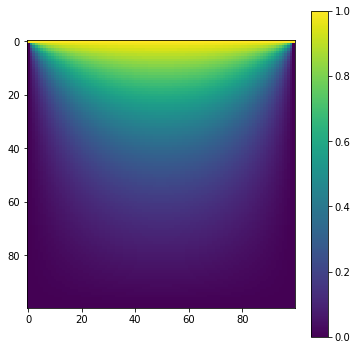

In [28]:
size = 100
V = np.zeros((size,size))
V[0,:]=1 #boundary condition: one side at constant (nonzero) potential, others grounded
for i in range(10000):
    V[1:-1,1:-1] = (V[2:,1:-1] + V[:-2,1:-1] + V[1:-1,2:] +V[1:-1,:-2])/4
plt.figure(figsize=(6,6))
plt.imshow(V)
plt.colorbar()

There exist more advanced techniques and codes, which triangulate in $n$-dimensional space, dynamically increase resolution where required, and use more advanced algorithms to actually solve the equation. The `integrate` module has a `solve_bvp` function that only works for 1-dimensional domains.

<a name="int"></a>
### Numerical integration

In the earlier examples, we were solving ODEs by integrating them. We can also numerically integrate functions. Essentially, we approximate a curve to a series of discrete boxes, and sum the sizes of each box to estimate the area under the curve, i.e. we sum over the values of function multiplied by the size of the domain that each value is meant to represent, $$\int_{x_1}^{x_N} f(x)\:dx\approx\sum_{i=1}^{N-1}f(x_i)(x_{i+1}-x_i).$$ (If we are integrating over an infinite domain, we should perform a transformation first to map it to a finite interval.) Don't forget the factors of $\Delta x$!

In [29]:
def simple_integrator(x, fn):
    return np.sum(fn(x)[:-1]*(x[1:]-x[:-1]))

Let's test it on some arbitrary polynomial

Text(0,0.5,'$f(x)$')

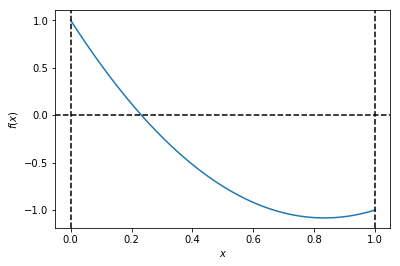

In [30]:
f = lambda x: 3*x**2-5*x+1
a = 0
b = 1

N = 100
x = np.linspace(a,b,N)
plt.plot(x,f(x))
plt.axhline(y=0, c="k", ls="--")
plt.axvline(x=a, c="k", ls="--")
plt.axvline(x=b, c="k", ls="--")
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

Text(0,0.5,'integral estimate')

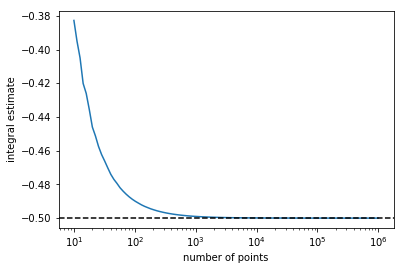

In [31]:
analytic_integral = b**3-a**3 - 2.5*(b**2-a**2) + b-a
Ns = np.logspace(1,6,100)
simple_estimates = [simple_integrator(np.linspace(a,b,int(N)), f) for N in Ns]
plt.plot(Ns, simple_estimates)
plt.axhline(y=analytic_integral, c="k", ls="--")
plt.xscale("log")
plt.xlabel("number of points")
plt.ylabel("integral estimate")

Text(0,0.5,'error in integral estimate')

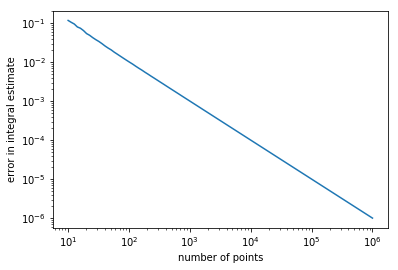

In [32]:
plt.plot(Ns, np.abs(np.array(simple_estimates)-analytic_integral))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("number of points")
plt.ylabel("error in integral estimate")

This seems to do pretty well. However, there are several integrators in `scipy.integrate` that are faster and more accurate than the simple one above, which only serves to demonstrate the principle of estimating an integral. For example, you could use a _quadrature_ to weight function values at different points differently in a way that effectively integrates a (typically polynomial) function interpolated betwen the sampled values, which increases accuracy (and is exact for low-order polynomials like our test function). The `quad` routine is a typical first choice for simple applications.

In [33]:
integrate.quad(f, a, b) #returns estimate and error

(-0.5, 7.993314959944701e-15)

For a physics example, consider the electric potential near a uniformly charged ring. In cylindrical coordinates, it is $$V(\rho,z)=\frac{kQ}{2\pi}\int_0^{2\pi}\frac{d\phi}{\sqrt{z^2+R^2+\rho^2-2R\rho\cos\phi}}.$$ This integral is difficult to do analytically (it can be expressed in terms of [complete elliptic integrals](http://mathworld.wolfram.com/EllipticIntegral.html)), but easy numerically. We can measure distance in units of $R$ and potential in units of $kQ/R$ to non-dimensionalise the problem.

Text(0.5,1,'$V(\\rho,z)$')

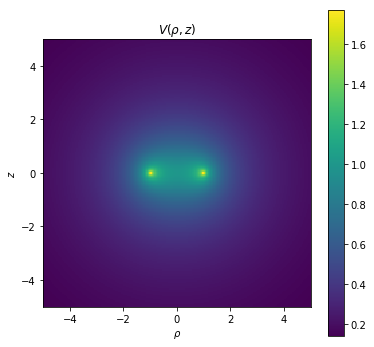

In [34]:
def V(rho, z):
    return integrate.quad(lambda phi: 1./np.sqrt(rho**2 + z**2 + 1 - 2*rho*np.cos(phi)), 0, 2*np.pi)[0]/2/np.pi #only return the estimate, not the error

bound = 5
N = 200
rhos = np.linspace(-bound, bound, N)
zs = np.linspace(-bound, bound, N)

Vs = [[V(r,z) for r in rhos] for z in zs]

f,ax = plt.subplots(1,1,figsize=(6,6))
im = ax.imshow(Vs, extent=(-bound,bound,-bound,bound), origin="lower")
plt.colorbar(im)
ax.set_aspect("equal")
ax.set_xlabel(r"$\rho$")
ax.set_ylabel("$z$")
ax.set_title(r"$V(\rho,z)$")

<a name="data"></a>
### Reading and writing data

It is easy to read and write plain text files. Let's store the ring potential data we just generated.

In [35]:
file = open("ring.txt", mode="w") #can use any other file extension instead of ".txt", but data will be written as plain text
file.write("rho,z,V\n") #"\n" is newline

rhos, zs = np.meshgrid(rhos, zs)
data = rhos.flatten(), zs.flatten(), np.array(Vs).flatten()
for datum in zip(*data):
    file.write(",".join(map(str,datum))+"\n")
    
file.close() #try opening it outside of the notebook

Now let's read the file and store the data as a list.

In [36]:
with open("ring.txt", mode="r") as file: #"w" mode for writing, "r" for reading
     #the with statement automaically closes the file after the indented block
    lines = file.readlines()

In [37]:
lines[:4]

['rho,z,V\n',
 '-5.0,-5.0,0.14105923929596564\n',
 '-4.949748743718593,-5.0,0.1417552873818454\n',
 '-4.899497487437186,-5.0,0.1424543331680154\n']

Now let's extract and plot the potential.

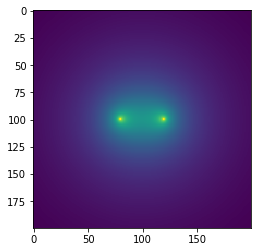

In [38]:
V = np.array([float(line.split(",")[2][:-2]) for line in lines[1:]]) #split the line, take 3rd entry, remove the "\n", convert to float
x = int(np.sqrt(len(V)))
plt.imshow(V.reshape((x,x)))

A common format for data compatible with any application is a comma-separated values, or _csv_ file.

In [39]:
import csv #module in-built to Python

file = open("ring.txt") #reading mode by default
ring_csv = csv.reader(file) #even though it's a txt file, it's in the csv format (delimited plain text)

ring_csv #this is an iterator

In [40]:
next(ring_csv)

['rho', 'z', 'V']

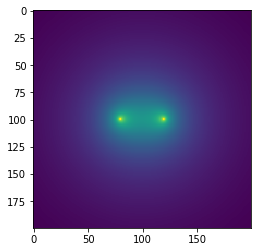

In [41]:
V = np.array([float(line[2]) for line in ring_csv]) #take 3rd entry, convert to float
x = int(np.sqrt(len(V)))
plt.imshow(V.reshape((x,x)))

In [42]:
file.close()

In [43]:
with open("ring.csv", mode="w") as file:
    ring_writer = csv.writer(file)
    for datum in zip(*data):
        ring_writer.writerow(datum)
#try opening it; compare with the .txt (then try changing the extension of the .txt to .csv)

You can also save and read numpy arrays in binary files, which is usually more efficient than encoding the data as strings, but less universal.

In [44]:
np.save("ring", Vs) #compare the three file sizes (this has only 1/3 of the data the other two have)

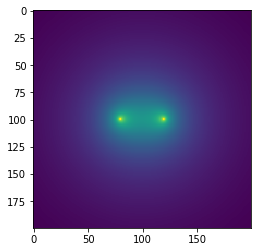

In [45]:
plt.imshow(np.load("ring.npy"))

There are also packages like [pandas](https://pandas.pydata.org/pandas-docs/version/0.22/10min.html) and [h5py](http://docs.h5py.org/en/stable/quick.html) that enable Python to interact with large datasets. Also, some applications have specific file formats, e.g. astronomers use [FITS](https://pythonhosted.org/pyfits/#quick-tutorial) files for sky maps.

<a name="fourier"></a>
### Fourier transforms

A common question in physics is how much of a particular signal is at a particular frequency. Thinking of functions as vectors, the Fourier transformation is simply a basis change (recall that it is linear). In this basis, derivatives are changed to factors of $k$ (wavenumber/frequency/momentum), which can also help solve differential equations. This is why physicists often like to think about and visualise things in Fourier space, and being able to compute it efficiently might help us also do so.

There are essentially four kinds of Fourier transforms:
1. continuous and infinite $$\tilde{F}(k)=\int_{-\infty}^\infty e^{ikx} F(x)\: dx$$
2. continuous and finite/periodic $$\tilde{F}(k)=\int_0^L e^{ikx} F(x)\: dx$$
3. discrete and infinite $$\tilde{F}_i = \sum_{j=-\infty}^\infty e^{ik_ix_j} F_j$$
4. discrete and finite/periodic $$\tilde{F}_i = \sum_{j=1}^N e^{ik_ix_j} F_j$$

The only one of these that we can compute on a digital computer with finite resources is the last one, which is called the _Discrete Fourier Transform_ (DFT). All of these transforms are analogous, so we can expect to gain intuition about the continuous and infinite cases even though we can only compute DFTs. We'd expect results to more accurately reflect those in the continuous limit for larger boxes and larger sampling rates (finer resolution).

the largest frequency that a DFT can accurately reconstruct is known as the Nyquist frequency. Since $k\sim 1/x$, the Nyquist frequency is determined by the resolution of the data (i.e. the sampling frequency), and the resolution in Fourier space (the $dk$) is determined by the total range of the data. Signals of frequency larger than the Nyquist frequency get folded back and forth within the observable window, which is known as [aliasing](https://xkcd.com/1814/). You might have noticed aliasing effects when looking at the wheels of a moving car. This can be used to estimate the sampling frequency of human vision (though it is not proof that the brain reconstructs vision from sampling). When taking discrete Fourier transforms, one must be aware of these  effects, and choose a sampling frequency accordingly.

The cell below interactively displays a plot of aliasing. Play around with it to understand how it works (there are no DFTs here). The interactivity comes from the [`ipywidgets` module](https://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html), which is part of the standard Python Jupyter kernel.

In [46]:
from ipywidgets import interactive #this will let us change an argument using a slider (or input it as text)

def aliasing_plot(frequency = 1):
    N = 20 #number of samples (- 1)
    
    xsampled = np.linspace(0,np.pi*N,N+1) #x grid for sampling (scaled such that Nyquist frequency is 1)
    xfine = np.linspace(0,np.pi*N,N*100) #x grid for plotting (same range but more samples)
    signal = np.cos(frequency*xfine) #input signal
    
    alias_frequency = min(frequency%2, -frequency%2) #frequency gets folded into the window [0,1]
    alias = np.cos(alias_frequency*xfine) #aliased signal (this is what a DFT would reconstruct)
    
    plt.figure(figsize=(15,4))
    plt.plot(xfine, signal, label=f"signal: $k={frequency:.2f}\:k_N$", c="gray")
    plt.plot(xfine, alias, label=f"alias: $k={alias_frequency:.2f}\:k_N$", c="r")
    plt.vlines(xsampled, -1.2*np.ones(N), np.cos(frequency*xsampled), label="samples", color="k", linewidth=2)
    plt.legend(loc="upper center", ncol=3, bbox_to_anchor=[0.5,1.15], frameon=False) #display legend above plot and in 1 line
    plt.ylim(-1.2,1.2)

interactive(aliasing_plot, frequency = (0., 5., 0.01)) #return an widget that interactively calls the function aliasing_plot
#the sliders are intialised using syntax similar to slicing

ModuleNotFoundError: No module named 'ipywidgets'

Now let's implement the 1-dimensional DFT:

In [ ]:
def slow_fourier(arr):
    N = len(arr)
    x = np.arange(N).reshape((-1,1)) #reshape for broadcasting
    k = np.arange(N).reshape((1,-1))*2*np.pi/N
    return np.sum(np.exp(1j*x*k)*arr, axis=-1)

In [ ]:
slow_fourier(np.ones(8))

The above implementation takes $\mathcal{O}(n^2)$ time to compute the DFT. But this can be made better using recursion, noting that \begin{align}\tilde F_j &= \sum_{k=1}^N e^{2\pi i jk/N}F_k \\&= \sum_{k=1}^{N/2}e^{2\pi i j(2k)/N}F_{2k}+\sum_{k=1}^{N/2}e^{2\pi i j(2k+1)/N}F_{2k+1} \\&= \sum_{k=1}^{N/2}e^{2\pi i jk/(N/2)}F_{2k}+e^{2\pi i j/N}\sum_{k=1}^{N/2}e^{2\pi i jk/(N/2)}F_{2k+1},\end{align} so we can compute the DFT of a size $N$ array if we already the know the DFTs of its odd-indexed and even-indexed sub-arrays of size $N/2$, which we will label $F^0$ and $F^1$. Thus (note that each sub-array only sees half the frequency range) the DFT formula is $$\tilde F_j =\tilde F^0_{j\:{\rm mod}\:N/2}+e^{2\pi i j/N}\tilde F^1_{j\:{\rm mod}\:N/2},$$ and by recursively computing the DFT we can do it in $\mathcal{O}(N\log N)$, which is a significant speed-up. Such algorithms are called _Fast Fourier Transforms_ (FFT). Here is the implementation of the algorithm, which is only valid for array sizes which are powers of two.

In [ ]:
def fast_fourier(arr):
    N = len(arr)
    if N==1: #termination: trivial dft
        return arr
    
    evens = fast_fourier(arr[::2]) #this is the recursive bit
    odds = fast_fourier(arr[1::2])
    
    ft = np.zeros(N, dtype=complex) #array to be returned
    N //= 2
    twiddles = np.exp(1j*np.pi*np.arange(N)/N)
    
    ft[:N] = evens + twiddles*odds
    ft[N:] = evens - twiddles*odds
    
    return ft

In [ ]:
fast_fourier(np.ones(8))

We can check that it is indeed faster.

In [ ]:
test_array = np.arange(256) #try different sizes, etc.
%timeit slow_fourier(test_array)
%timeit fast_fourier(test_array)

The algorithm described above for factors of two can easily be generalised to any factor. The _Cooley-Tukey_ algorithm recursively factorises an array of length $N$ to compute its DFT, which is $\mathcal{O}(N \log N)$ for highly factorisable $N$, and $\mathcal{O}(N^2)$ for prime $N$. This algorithm is part of [numpy's `fft` module](https://docs.scipy.org/doc/numpy/reference/routines.fft.html). If you're planning to compute Fourier transforms, it's better to choose factorisable array sizes (powers of 2 are optimal).

In [ ]:
test_array = np.arange(2**13)
%timeit np.fft.fft(test_array) #size 8192: maximum factorisability
%timeit np.fft.fft(test_array[:-1]) #size 8191: mersenne prime

Let's compare the efficiencies of the DFT algorithms we have.

In [ ]:
import time

maxsize = 10
functions_to_test = {"slow": slow_fourier, "fast": fast_fourier, "numpy": np.fft.fft} #dict of functions with labels

test_arr = np.ones(2**maxsize) #one master test array, we'll slice subarrays for each test
sizes = 2**(np.arange(maxsize)+1) #size of each test subarray

for label in functions_to_test:
    fn = functions_to_test[label] #this is the function to test
    times = []
    for i in range(maxsize):
        arr = test_arr[:sizes[i]] #get array of right size
        start = time.time()
        fn(arr) #time DFT
        times.append(time.time()-start)
    plt.plot(sizes, times, label=label, marker="x")

plt.xlabel("array size")
plt.ylabel("computation time [seconds]")
plt.legend(frameon=False)
plt.xscale("log")
plt.yscale("log")
plt.title("1-d DFT")

The FFT scales much faster, and as expected numpy is a few orders of magnitude faster than our Python implementation, though it scales the same way.

Here is an interactive cell that visualises the 1-d of the Fourier transforms of common functions. Play around with it to get a sense of what the Fourier transform does.

In [ ]:
shapes = {} #dict of input shape functions. feel free to add something you want to see
shapes["sinusoid"] = lambda x,c,w: np.cos(2*np.pi*(x-c)/w)
shapes["linear"] = lambda x,c,w: (x-c)/w
shapes["quadratic"] = lambda x,c,w: (x-c)**2/w**2
shapes["gaussian"] = lambda x,c,w: np.exp(-(x-c)**2/2/w**2)
shapes["top hat"] = lambda x,c,w: (x > c-w)*(x < c+w)*1.
shapes["triangle"] = lambda x,c,w: np.maximum(1-np.abs((x-c)*2/w),0)

def fourier_plot(shape="top hat", samples=100, centre=0, width=0.1):
    x_grid = np.linspace(-.5, .5, samples)
    signal = shapes[shape](x_grid,centre,width) #input signal
    fk = np.fft.fft(np.fft.fftshift(signal)) #shift signal so x=0 is at index 0 (DFT is periodic)
    
    fk = np.fft.fftshift(fk) #shift so that the zero mode is in the centre, not at index 0
    k = np.fft.fftshift(np.fft.fftfreq(samples, d=1/samples)*2*np.pi) #frequencies corresponding to FT (spacing is 1/samples)
    
    f,ax = plt.subplots(2, 1, figsize=(15,8), gridspec_kw={"hspace": 0.25})
    
    ax[0].plot(x_grid, signal)
    ax[0].set_xlabel("$x$")
    ax[0].set_ylabel("$f(x)$")
    ax[0].set_title("real space")
    
    ax[1].plot(k, np.abs(fk), label="modulus", linewidth=2.2)
    ax[1].plot(k, np.real(fk), label="real")
    ax[1].plot(k, np.imag(fk), label="imaginary")
    ax[1].legend(frameon=False)
    ax[1].set_xlabel("$k$")
    ax[1].set_ylabel(r"$\tilde{f}(k)$")
    ax[1].set_title("momentum space")

interactive(fourier_plot, shape=shapes.keys(), samples=(10,500,10), centre=(-.5,.5,.01), width=(0.001,0.5,0.005))
#when we pass a list of strings to intialise a slider, we get a dropdown

You might have noticed that because we've using real input, only half the displayed momentum space is independent: $F_k=F_{-k}^*$. `numpy.fft` has functions `rfftn()` and `irfftn()` for real inputs and outputs that only work with half the momentum space.

Let's use the Fourier transform to analyse some data. Here's a recognisable photograph:

In [ ]:
im = plt.imread("campanile.jpg")
im = 0.2989*im[:,:,0] + 0.5870*im[:,:,1] + 0.1140*im[:,:,2] #convert rgb to grayscale (all colours are not equally important)

plt.figure(figsize=(16,9))
plt.imshow(im, cmap="gray")
plt.axis("off")

im.shape

And this is the absolute value of its Fourier tranform:

In [ ]:
from matplotlib.colors import LogNorm #for log-normalised colourmaps

plt.figure(figsize=(8,8))
plt.imshow(np.fft.fftshift(np.abs(np.fft.fft2(im))), norm=LogNorm(), extent=[-np.pi,np.pi]*2)
#we pass an instance of a Normalizer class that is used to scale the data (you can pass bounds if necessary)
#then a colourmap is applied to it. it currently uses the default colourmap, but we have already seen 3 of them
plt.colorbar()
plt.xlabel("$k_x$")
plt.ylabel("$k_y$")
plt.title("$|F_k|$")

Now we'll manipulate the image in Fourier space, and see what that does to it in real space. Let's define a wrapper to apply a function to the image's Fourier transform, transform back to real space, and then display the image.

In [ ]:
def fourier_manipulate(fn):
    ftim = fn(np.fft.fft2(im))
    plt.figure(figsize=(16,9))
    plt.imshow(np.real(np.fft.ifft2(ftim)), cmap="gray")
    plt.axis("off")

If we don't change it at all, we should recover the original image.

In [ ]:
fourier_manipulate(lambda x: x)

Now let's try discarding all the high-frequency information (i.e. cropping in Fourier space).

In [ ]:
def remove_high_k(ft):
    ft[100:-100]=0
    ft[:,200:-200]=0
    return ft

fourier_manipulate(remove_high_k)

Cropping in Fourier space is equivalent to changing the resolution in real space. Since we reduced the maximum frequency by about a factor of 10, we also reduced the resolution similarly, so we have lost all information on scales smaller than 10 pixels. 

Since the high-frequency information has small-scale information and vice-versa, by amplifying signals at higher frequencies, we can increase the detail in the image. This is known as _sharpening_.

In [ ]:
ky, kx = np.meshgrid(np.fft.fftfreq(im.shape[0]), np.fft.fftfreq(im.shape[1]), indexing="ij") #frequency components
k = np.sqrt(kx**2+ky**2) #array representing total size of frequency

In [ ]:
amplify_large_k = lambda ft: ft*(.5+k)**2 

#we are multiplying the array by k**2 in fourier space to amplify local information
#we add .5 to k so that we don't overly suprress small k

fourier_manipulate(amplify_large_k)

We can do the opposite to _blur_ the photogtaph. Here we multiply by a Gaussian to suppress large $k$.

In [ ]:
gaussian_blur = lambda ft: ft*np.exp(-50*k**2)
fourier_manipulate(gaussian_blur)

In the above two examples, we multiplied the image with a kernel in Fourier space. This is equivalent to [_convolving_](http://mathworld.wolfram.com/Convolution.html) in real space with the Fourier transform of the Fourier-space kernel used for multiplication. It is actually more efficient to implement a convolution (which would usually take $\mathcal{O}(N^2)$ in 1 dimension) by transforming to and back from Fourier space, unless the convolution kernel is small, as is the case for most image processing techniques. You can visualise the convolution kernels corresponding to the operations above by Fourier transforming the arrays we used to multiply (or using the interactive cell earlier in this section). Essentially, sharpening/blurring amplifies/supresses the difference between each pixel and its neighbours, and corresonding convolution kernels would look like `[-0.25,1.5,-0.25]`/`[0.25,0.5,0.25]`.

"Sharpening" also describes the relation between e.g. a potential and source density, since $\Phi = -\nabla^2\rho=k^2\rho$.

We can also look for edges in a particular direction by amplifying the corresponding elements of the Fourier transform.

In [ ]:
horizontal_edges = lambda ft: ft*np.abs(ky) #amplifying modes with lots of y-momentum
fourier_manipulate(horizontal_edges)

In [ ]:
vertical_edges = lambda ft: ft*np.abs(kx) #amplifying modes with lots of x-momentum
fourier_manipulate(vertical_edges)

Convolutions are used a lot in image and data processing, and are very useful to get rid of noise (by blurring). they are also used for image recognition (in the same spirit as edge detection), particularly in machine learning. Convolutions also naturally arise in probability theory when combining random variables. You can easily perform discrete convolutions in Python using `numpy.convolve()`. (When dealing with convolutions, it might be useful to remember that Gaussians are closed under convolution, i.e. the convolution of two Guassians is another Gaussian.)

<a name="fit"></a>
### Fitting

A common problem, particularly in experimental physics, is fitting some data $\{(x_i,y_i)\}$ to a theoretical curve $f(x)$, which depends on some parameters $\theta$. This amounts to choosing parameters to best explain the data. The most common approach is to define a loss function $L(\theta)$, which quantifies how far away the data is from the theoretical predictions, and choose the $\theta$ that minimises $L$, i.e. optimise $L$ over $\theta$.

Optimisation is an ubiquitous problem. All of physics comes from the optimisation of the action. Evolution is the natural optimisation of life's ability to survive. A similar thing applies to businesses in the free market, which optimise profit. The philosophy of utilitarianism is based on the assumption that people have utility functions over which they optimise their decisions. In this view, life is nothing but a series of choices in which we are forced to optimise over our given utility functions, and this is indeed the philosophy on which concepts such as social utility and government are built. Neural networks are able to learn by optimising internal parameters in response to external input; perhaps we also learn in a similar way. Needless to say, optimisation is a rich and lucrative field of study in mathematics and computer science.

When one is at the minimum (maximum) of a function, any variations would increase (reduce) the function value, so we have $$\left.\frac{dL}{d\theta}\right|_{\theta=\theta_{\rm opt}}=0,$$ and since we are minimising $L$ the second derivative at the optimum value must be positive. A common choice for $L(\theta)$ is the squared difference between the expected and measured data points, $$L(\theta) = \sum_i(y_i-f(x_i,\theta))^2.$$ This is called _least squares regression_.

When the fitting function is linear in the parameters, e.g. for polynomial fitting $f(x,\theta) = \sum_{n=0}^d\theta_nx^n$, then the loss function is convex, which guarantees that a local minimum is a global minimum, so one simply has to solve $\frac{d L}{d\theta_n}=0$. This is a linear problem, so can be solved by inverting a matrix (whose size is the number of data points). In Python, you could use `numpy.polyfit()`, `numpy.linalg.lstsq()`, `numpy.Polynomial.fit()`, or any other implementation.

In [ ]:
x, y = np.load("mystery_array.npy")
plt.scatter(x, y, marker="x", alpha=0.3) #alpha is transparency
len(x)

In [ ]:
def loss(fn, theta, x, y):
    predicted = fn(x, *theta)
    return np.sum((y - predicted)**2)

In [ ]:
linear = lambda x, t0, t1: x*t0 + t1

extent = [0,5,-5,5]
m = np.linspace(*extent[:2],200)
y0 = np.linspace(*extent[2:],200)

losses = np.array([[loss(linear, (slope,intercept), x, y) for slope in m] for intercept in y0])
p = np.polynomial.Polynomial.fit(x,y,1).convert().coef[::-1] #find best-fit params

plt.figure(figsize=((extent[1]-extent[0]),0.8*(extent[3]-extent[2]))) #calculate appropriate figsize (including colourbar)
plt.imshow(1/losses, extent=extent, origin="lower") #plot 1/loss for easy viewing
plt.colorbar()
plt.scatter(*p, marker="x", c="r")
plt.xlabel("slope")
plt.ylabel("$y$-intercept")

p

In [ ]:
plt.scatter(x,y,marker="x",alpha=0.3)
bounds = np.array([np.amin(x),np.amax(x)])
plt.plot(bounds, bounds*p[0]+p[1], c="r")
len(x)

A common model for a wide variety of physics quantities is a _power-law_, $f(x)\propto x^\alpha$, where the exponent is a physically relevant parameter that is to be fit. In this case, we can use a linear fitting function in log-space. In fact, the data in `mystery_array.npy` has already been transformed to log-space, as can be confirmed by transforming back.

In [ ]:
ey,ex = np.exp(y), np.exp(x)
ex[:20], ey[:20] #note that they're all integers: maybe x and y were originally obtained from ex and ey

The most common type of non-linear optimisation algorithm is gradient descent, in which one iteratively updates the guess in the direction opposite to the gradient, similarly to Newton's method. For an example of non-linear optimisation, let's explicitly fit the data to a power law using the [`scipy.optimize` module](https://docs.scipy.org/doc/scipy-0.19.0/reference/optimize.html).

In [ ]:
from scipy.optimize import curve_fit

power_law = lambda x, t0, t1: np.exp(t1)*x**t0

losses = np.array([[loss(power_law, (slope,intercept), ex, ey) for slope in m] for intercept in y0])
p2 = curve_fit(power_law, ex, ey)[0] #find best-fit params

plt.figure(figsize=((extent[1]-extent[0]),0.8*(extent[3]-extent[2])))
plt.imshow(1/losses, extent=extent, origin="lower") #plot 1/loss for easy viewing
plt.colorbar()
plt.scatter(*p, marker="x", c="k")
plt.scatter(*p2, marker="x", c="r")
plt.xlabel("slope")
plt.ylabel("$y$-intercept")

p2

The result we get is different from the linear fit in log-space! Let's plot both.

In [ ]:
plt.scatter(ex, ey, marker="x", alpha=0.3)

xmesh = np.linspace(np.amin(ex),np.amax(ex),1000)
plt.plot(xmesh, np.exp(p[1])*xmesh**p[0], c="k", label="linear fit")
plt.plot(xmesh, np.exp(p2[1])*xmesh**p2[0], c="r", label="non-linear fit")
plt.legend(frameon=False)

#plt.xscale("log");plt.yscale("log") #uncomment this line (the semicolon acts as a line break)

The difference between the two fits is that the one in log-space gives more importance to measurements with low-magnitude `y` values than the raw data. This may or may not be desirable depending on the specific applications. When using fitting to estimate parameters, you can estimate the errors on your estimates (assuming Gaussian errors) using the covariance matrix returned by the fitting functions used above. For more information as well as a discussion of fitting and model complexity, see the `Intro to stats.ipynb` notebook.

A related task to fitting is _interpolation_, in which we approximate a function based on some samples. Interpolation can be useful to approximate a function that is difficult to evaluate, smoothen data, and to obtain better looking graphics. A common choice for interpolation is to approximate the samples using a piecewise polynomial, known as a _spline_. For "smooth" functions, we'd expect the spline to be at least twice diffferentiable, which means the polynomials must be at least cubic. While we don't show you how to use the tools here, there are several interpolation tools in the [`scipy.interpolate` module](https://docs.scipy.org/doc/scipy/reference/interpolate.html), and the documentation is rather straightforward. <font color="red">Should I give an example?</font>

<a name="stats"></a>
### Random numbers

Computers are deterministic. A program will run will always run the same way from the same initial state. However, there are several algorithms that, given an initial number, return a series of numbers that are difficult to predict, and are effectively random. These are called pseudo-random number generators, also referred to as random number generators (RNGs). Random numbers have a variety of uses, from security/cryptography to video games to solving problems by simulating stochastic systems. There are algorithms that claim to provide "true" randomness, usually based on some physical measurement, but whether or not something is truly random is a matter of lengthy debate. For most applications we simply require numbers that roughly evenly sample some target space and are free of the particular types of correlation that would interfere with our specific application. Python has a `random` suite built-in, but we shall use the `numpy.random` module.

In [ ]:
np.random.rand(5) #random floats between 0 and 1
#try running this a few times

The determinism of computers can also be useful as it enables reproducability. By explicitly setting a _seed_, which determines all the random numbers generator after seeding and before re-seeding, we can ensure that we can reproduce the exact same sequence of "random numbers" if required. This is useful while debugging, and when cross-checking someone else's methods. Therefore, it is considered good practice to explicitly seed all the RNGs you use, especially if you are sharing the code or results produced from it.

Since the state of the `numpy` RNG is represented by a 32-bit integer, the seed must be an integer that is less than $2^{32}$. If you don't explicitly set a seed, the RNG will typically be initialised using the clock time or some other "random" source.

In [ ]:
np.random.seed(13486313) #try changing this and running a few times
np.random.rand(5)

In [ ]:
np.random.randint(100, size=10)

Estimating the statistical moments of a distribution from a sample is easy:

In [ ]:
def mean(array):
    return np.sum(array)/len(array)

def standard_deviation(array):
    return (np.sum(array**2)/len(array)-mean(array)**2)**.5

In [ ]:
x = np.random.rand(500)
%time mean(x), standard_deviation(x)

These functions (and more) are already built-in to numpy, but aren't faster than the (also numpy) implementation above.

In [ ]:
%time np.mean(x), np.std(x)

You might notice that the output of `np.std()` differs from that of our `standard_deviation()` implementation. This is because we haven't included Bessel's correction which increases the estimate of variance by a factor of $\frac{N}{N-1}$ to account for the fact that the variance estimate only involves $N-1$ degrees of freedom since one is used to estimate the mean. (This is neglibile for large $N$.)
 
Analytically, $\langle x \rangle =\int_0^1 x\:dx=\frac{1}{2}$ and $\langle x^2 \rangle =\int_0^1 x^2\:dx=\frac{1}{3}$, so the uniform distribution between 0 and 1 has mean $\frac{1}{2}$ and standard deviation $\sqrt{\frac{1}{12}}\approx 0.289$. How many points do we need to sample to get an accurate estimate of the mean and standard deviation?

In [ ]:
np.random.seed(875309) #try running this cell for a few different seeds

n = 500 #number of points on each line
nlines = 10
Ns = np.logspace(1, 6, n, dtype=int)

f, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0.05}, figsize=(6,8))
#2 plots: one for value and other for error, with same x-axis

for i in range(nlines):
    sims = np.random.rand(int(Ns[-1])) #sample random numbers

    #compute means, variances of the first N sample (for various Ns)
    means = np.array([mean(sims[:N]) for N in Ns])
    devs = np.array([np.std(sims[:N]) for N in Ns])

    #plot values
    ax[0].plot(Ns, means, c="k", alpha=0.3)
    ax[0].plot(Ns, devs, c="r", alpha=0.3)
    
    #plot errors
    ax[1].plot(Ns, np.abs(means*2-1), c="k", alpha=0.3)
    ax[1].plot(Ns, np.abs(devs*12**.5-1), c="r", alpha=0.3)

#add theoretical expectations as horizontal dashed line 
#across entire axis (doesn't need x-values, only a y-value)
ax[0].axhline(y=0.5, c="k", label="mean", ls="--")
ax[0].axhline(y=12**-0.5, c="r", label="standard deviation", ls="--")

ax[0].set_xscale("log")
ax[0].set_ylabel("value")
ax[0].legend(frameon=False)

ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_ylabel("relative error")
ax[1].set_xlabel("number of samples")

We can do a best-fit here, but we shall return to it later.

Histograms are an effective way of visualising distributions. Histograms split the domain into discrete intervals called _bins_ and display the counts, i.e. the number of samples, that fall in each bin. The effectiveness of a histogram is very sensitive to the binning chosen, and this choice is often a tradeoff between resolution and randomness, since for finer binning resolutions the bin counts become more random (i.e. the standard deviation becomes larger compared to the mean). Here is a histogram of 500 "uniformly distributed" samples from the numpy RNG.

In [ ]:
plt.hist(np.random.rand(500)) #10 bins by default
#notice it returns a 3-tuple containing the counts, the bin edges, and the actual plotted rectangle objects
#try running it a few times: it is random

Above, we use `matplotlib.pyplot.hist()` to directly plot a histogram from samples. To only compute the bins and counts, use `numpy.histogram()` or `scipy.stats.binned_statistic()`. 

In a histogram, each bin has a probability $p=\int_{\rm bin}\rho(x)\:dx$ of receiving each sample (for small bins this can be approximated to $p\approx V_{\rm bin}\rho(x_{\rm bin})$). If the samples are independent, the total number of counts in each bin is given by a binomial distribution. In the following histogram we've added lines indicating the expected number of counts in each bin, as well as the region that is within 1 standard deviation of the mean (for Gaussian probability distributions, this is called 1-$\sigma$).

In [ ]:
np.random.seed(3332345) #run it a few times with different seeds

#play around with these
N=1000
nbins=20

samples = np.random.rand(N)
plt.hist(samples, bins=nbins) #set the bin edges or the number of bins using the bins keyword

p = 1/nbins #probability of each sample going in each bin
m = N*p #mean of counts in each bin (binomial dist)
s = (N*p*(1-p))**.5 #standard deviation of counts in each bin

plt.axhline(m, c="r")
plt.axhline(m+s, c="r", ls="--", alpha=0.5)
plt.axhline(m-s, c="r", ls="--", alpha=0.5)
plt.axhspan(m-s, m+s, color="r", alpha=0.25) #colour the range between two x-values

To verify that the probability distribution of the counts of each bin is indeed the binomial distribution, we draw `N1` samples from the uniform distribution, bin them into `nbins` bins and track the counts we see in a randomly chosen bin for `N2` trials. Again, the frequency of each bin is probabalistic, and is described by a binomial distribution, and again we plot the theoretical expectations. (However, the noise can be very low compared to the signal for large `N2`.) For large `N1/nbins` you might notice that the binomial distribution looks like a Gaussian.

In [ ]:
from scipy.stats import binom #binomial distribution object (see docs)

#np.random.seed(958643)

#try playing around with these three values (make it interactive if you want)
N1 = 100 #number of samples in original histogram
N2 = 1000 #number of samples in final histograms (number of initial histograms)
nbins = 10 #number of bins in initial histogram (since counts are discrete, bin width of final histogram is 1)

i = np.random.randint(nbins) #randomly choose which bin to plot distribution of
edges = np.linspace(0,1,nbins+1) #keep same bin edges for each sample
counts = np.zeros(N2, dtype=int)
for j in range(N2):
    counts[j] = np.histogram(np.random.rand(N1), edges)[0][i]
    #np.histogram() returns tuple of counts and edges, we only extract the count we want

count_mesh = np.arange(np.amin(counts), np.amax(counts)+1) #create mesh of counts in relevant range
bin_edges = np.arange(np.amin(counts)-0.5, np.amax(counts)+1) #bin edges centred on integer counts

plt.hist(counts, bin_edges)

theo_probs = binom.pmf(count_mesh, N1, 1/nbins) #theoretical probability of each count
exp = theo_probs*N2 #mean of each bi
lower, upper =  binom.interval(.9, N2, theo_probs)
#90% confidence intervals of each bin, better than using std dev for small bin counts

plt.plot(count_mesh, exp, c="r") #plot theoretical expectations
plt.plot(count_mesh, lower, ls="--", c="r", alpha=0.5)
plt.plot(count_mesh, upper, ls="--", c="r", alpha=0.5)
plt.fill_between(count_mesh, lower, upper, color="r", alpha=0.25) #colours area between lines

plt.xlabel("bin count")
plt.ylabel("number of counts")
#plt.yscale("log") #try out the log-scale

One statistic that is sometimes used to test whether a histogram (or any other set of categorical, independent data) was sampled from a hypothetical distribution is the $\chi^2$ statistic, $$\chi^2=\sum_{i=1}^k\frac{(N_i-E_i)^2}{E_i},$$ where $N_i$ and $E_i$ are the observed and expected counts for each of the $k$ categories. If the data is indeed sampled from the hypothetical distribution (which is known as the null hypothesis) then the probability distribution of the $\chi^2$ statistic converges to a $\chi^2$ distribution with $k-1$ degrees of freedom (since $N=\sum_iN_i$ is fixed) in the limit of infinite data. Given some data one can test the null hypothesis by comparing the $\chi^2$ statistic to the corresponding distribution and obtaining a $p$-value. <font color="red">Add links for $\chi^2$, $p$-values?</font>

In the following cell we'll apply the $\chi^2$ test to the above cell, to test whether the count of a bin in a histogram really follows a binomial distribution. We'll do this `N3` times to obtain `N3` $\chi^2$ values, which we will compare to a $\chi^2$ distribution, obtaining `N3` $p$-values, which we compare to the uniform distribution. The [`scipy.stats` module](https://docs.scipy.org/doc/scipy/reference/stats.html) has a `chisquare()` function for testing as well as a `chi2` class for using the distribution.

In [ ]:
from scipy.stats import chisquare #see docs

#np.random.seed(958643)

#try playing around with these three values (make it interactive if you want)
N1 = 20 #number of samples in original histogram
N2 = 1000 #number of samples in final histograms (number of initial histograms)
         #the chi^2 distribution describes the statistic in the limit N2 -> inf
nbins = 3 #number of bins in initial histogram (since counts are discrete, bin width of final histogram is 1)
N3 = 500 #number of chi^2 tests to run
k = 10 #bins for chi^2 test

i = np.random.randint(nbins) #randomly choose which bin to plot distribution of
edges = np.linspace(0,1,nbins+1) #keep same bin edges for each sample
counts = np.zeros((N3,N2), dtype=int)
for j in range(N3):
    for l in range(N2):
        counts[j,l] = np.histogram(np.random.rand(N1), edges)[0][i] #returns tuple of counts and edges, we only extract the count we want

#find reasonable bounds for the binning: 3-sigma or min/max, whichever one's tighter
m,s = np.mean(counts), np.std(counts)
lower = max(m-3*s, np.amin(counts))
upper = min(m+3*s, np.amax(counts))

#bin the data into the categorical distribution of which we can compute the chi^2 statistic
count_edges = np.linspace(lower, upper, k+1)
count_edges[0], count_edges[-1] = -np.inf, np.inf
observed_counts = np.zeros((N3,k), dtype=int)
for j in range(N3):
    observed_counts[j] = np.histogram(counts[j], bins=count_edges)[0]

expected_counts = binom.cdf(count_edges, N1, 1/nbins) #probability of each bin
expected_counts = expected_counts[1:]-expected_counts[:-1]
expected_counts *= N2
print(expected_counts) #to check if binning is ok

c, p = chisquare(observed_counts, expected_counts, axis=-1)
print(c[:10],p[:10])

In [ ]:
from scipy.stats import chi2

nbins_plot = 20

edges = plt.hist(c, bins = nbins_plot)[1]
centres = (edges[1:]+edges[:-1])/2

expected = np.diff(chi2.cdf(edges, k-1)) #probability of each bin = cdf(right_edge)-cdf(left_edge)
interval = binom.interval(0.9, N3, expected)

plt.plot(centres, expected*N3, c="r")
plt.plot(centres, interval[0], ls="--", c="r", alpha=0.5)
plt.plot(centres, interval[1], ls="--", c="r", alpha=0.5)
plt.fill_between(centres, *interval, color="r", alpha=0.25)

plt.xlabel(r"$\chi^2$")
plt.ylabel("number of counts")

In [ ]:
plt.hist(p, bins = nbins_plot)

prob = 1/nbins_plot #theoretical probability of each sample going in each bin
m = N3*prob #expected counts in each bin (binomial dist)
interval = binom.interval(0.9, N3, prob) #90% confidence interval of counts

plt.axhline(m, c="r")
plt.axhline(interval[0], c="r", ls="--", alpha=0.5)
plt.axhline(interval[1], c="r", ls="--", alpha=0.5)
plt.axhspan(*interval, color="r", alpha=0.25)
plt.xlabel("$p$-value")

We can also compine our multiple $p$-values into one $p$-value using Fisher's test:

In [ ]:
from scipy.stats import combine_pvalues

combined_chi2, combined_p = combine_pvalues(p)
combined_p

The binomial distribution is the distribution of the sum of $n$ independent and identically distributed (i.i.d) binary random varies with probability $p$ of being 1 and $1-p$ of being 0. The fact that for large $n$ the binomial distribution becomes the normal distribution is an example of the _central limit theorem_, which states that if you sum or average a large number of i.i.d random variables, you will obtain a random variable that is described by a Gaussian probability distribution, regradless of the probability distribution of each variable that you start with.

Let's start with the uniform probability distribution between 0 and 1 since we know how to sample from it. Analytically, the probability distribution of the sum of $n$ independent, uniformly distributed random numbers $x = \sum_{i=1}^nx_i$ is $$\rho(x) = \prod_{i=1}^n\left(\int dx_i\:\rho(x_i)\right)\delta\!\left(x-\sum_{i=1}^nx_i\right)=\int_{\max(0,\,x+1-n)}^{\min(1,\,x)}dx_1\int_{\max(0,\,x-x_1+2-n)}^{\min(1,\,x-x_1)}dx_2\cdots\int_{\max(0,\,x-x_1\cdots-x_{n-2}-1)}^{\min(1,\,x-x_1\cdots-x_{n-2})}dx_{n-1},$$ where the $\delta$ is the Dirac delta distribution. While we can easily use a computer to evaluate this symbolically (to obtain a series of increasingly differentiable piecewise polynomials that converges to the normal distribution, which might be useful), let's integrate numerically, and compare the efficiencies of finding the distribution by numerical integration and by direct sampling. Techniques that estimate quantities by sampling random numbers are known as _Monte Carlo_ techniques since they gamble to find the answer.

In [ ]:
def nth_pdf(x,n):
    if x>=n or x<= 0:
        return 0
    return nth_helper(x,n-1)
    
def nth_helper(x,n_left): #recursively perform nested integral
    if n_left==0:
        return 1
    return integrate.quad(lambda xi: nth_helper(x-xi,n_left-1), max(0,x-n_left), min(1,x))[0]

In [ ]:
import time

gaussian = lambda x, mu, sigma: np.exp(-(x-mu)**2/2/sigma**2)/sigma/(2*np.pi)**.5
#this is the definition of a gaussian prob. distribution 
#we could have just used a scipy function, but you really should know this (upto normalisation)

N=100
n_max = 4
f,ax = plt.subplots(n_max, 1, figsize=(6,4*n_max))
for n in np.arange(n_max)+1:
    xs = np.linspace(0,n,N)
    
    start = time.time()
    samples = np.sum(np.random.rand(N*1000,n), axis=1) #simulate the process by adding N random numbers
    sampling_time = time.time()-start
    
    start = time.time()
    pdf = [nth_pdf(x,n) for x in xs] #do the n-1 integrals numerically for each x
    integrating_time = time.time() - start
    
    print(f"n={n}, sampling time: {sampling_time:.6f}, integrating time: {integrating_time:.6f}")
    
    ax[n-1].hist(samples, bins=N, density=True)
    ax[n-1].plot(xs, pdf, label="analytic")
    ax[n-1].plot(xs, gaussian(xs, mean(samples), np.std(samples)), label="Gaussian") #gaussian approximation
    ax[n-1].set_title(f"$n={n}$")
    ax[n-1].legend(frameon=False)

We can see that as we increase $n$ the distribution gets more smoothed out, looking more like a Gaussian. Also, we can't numerically integrate beyond $n=4$ with our current integration method (which is inefficient, but would still scale poorly no matter how much we optimised it), while the sampling complexity scales linearly with $n$. This is why, in higher dimensions, Monte Carlo techniques based on sampling are more effective than other numerical techniques. Let's look at a couple of pictures of large $n$.

In [ ]:
N = 10000
nbins = 50
n_max = 3
ns = np.logspace(1,n_max,n_max,dtype=int)

f,ax = plt.subplots(n_max, 1, figsize=(6,4*n_max))
for i,n in enumerate(ns):
    samples = np.sum(np.random.rand(N,n), axis=1) #simulate the process by adding N random numbers
    
    counts, edges, patches = ax[i].hist(samples, bins=nbins, density=True)
    ax[i].plot(edges, gaussian(edges, mean(samples), np.std(samples)), label="Gaussian") #gaussian approximation
    ax[i].set_title(f"$n={n}$")
    ax[i].legend(frameon=False)

We see that the Gaussian approximation is good for large $n$. It isn't hard to see where the central limit theorem comes from. Assuming the initial probability distribution has a mean $\mu$ and standard deviation $\sigma$, $$\langle x\rangle = \sum_i \langle x_i\rangle = N\mu,\\\langle (x-\overline{x})^2\rangle=\sum_{i,j}\langle (x_i-\mu)(x_j-\mu)\rangle=\sum_i\langle (x_i-\mu)^2\rangle=N\sigma^2,$$ and so on. Thus, while the mean scales linearly with $n$, the standard deviation scales like $\sqrt{n}$, which means the signal-to-noise ratio scales like ${1}/{\sqrt{n}}$, which is why averaging over larger domains reduces noise. We can test these relations numerically for the uniform distribution (feel free to try another ditribution).

In [ ]:
Npoints = 500
ns = np.logspace(1, 4, Npoints, dtype=int)
Nsamples = 50
means = np.zeros(Npoints)
devs = np.zeros(Npoints)

for i in range(Npoints):
    #sum over n uniform randoms Nsamples times to obtain an array of size Nsamples
    samples = np.sum(np.random.rand(Nsamples,ns[i]), axis=1)
    #compute and store its mean and variance
    means[i] = np.mean(samples)
    devs[i] = np.std(samples)
    
plt.plot(ns, means, c="k", label="sample mean")
plt.plot(ns, ns/2, c="k", ls="--")
plt.plot(ns, devs, c="r", label="sample standard deviation")
plt.plot(ns, (ns/12)**0.5, c="r", ls="--")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("$n$")
plt.ylabel("sum of $n$ uniform deviates")
plt.title(f"sample size = {Nsamples}")
plt.legend(frameon=False)

We see extremely good agreement between theory and "experiment". We have now answered the question of how many samples we need to get an estimate of the mean: our error can be estimated by the sample standard deviation divided by $\sqrt{n}$.

The central limit theorem justifies the ubiquity of Gaussians in statistics and physics. Gaussians are extremely well-studied: we know how to analytically integrate any function over a Gaussian probability distribution. If we are unsure of the form of an unknown distribution, a typical first guess would be that it is Gaussian, usually justified less by the central limit theorem and more by aestheticism. We'd recommend exercise at least some modicum of caution before rushing to the conclusion that everything is Gaussian. You can sample from the standard normal distribution (a Gaussian with $\mu=0$ and $\sigma=1$) using `numpy.ranom.randn()`:

In [ ]:
nbins = 50
samples = np.random.randn(nbins*100) #samples from Gaussian
counts, edges, patches = plt.hist(samples, bins=nbins, density=True)
plt.plot(edges, gaussian(edges,0,1))

The cumulative density function of a Gaussian is actually a difficult integral that has no closed form. It is usually evaluated numerically and is known as the _error function_. In Python, you can find the error function in `scipy.special`, or you can use the `cdf()` method of the `scipy.stats.norm` object.

You'd be surprised to learn until how recently people used to used tables for common mathematical functions or distributions like logarithms, $\chi^2$s, and Gaussians. Some people are still taught how to use these tables in school! In the past 20 years, digital computing has completely revolutionised the way people have been doing mathematics for thousands of years. If you'd like to learn more, we'd recommend visiting the Computer History Museum in Mountain View.